## Utilizing Net Load Data to Design an Optimal Schedule for a Battery Storage System in a Low-Voltage Substation



# Introduction

In recent years, the use of renewable energy sources such as solar photovoltaic (PV) has increased significantly due to their low carbon emissions and reduced costs. However, the intermittent nature of renewable energy sources poses challenges for grid stability and reliability. Battery storage systems have been identified as a promising solution to address these challenges by storing excess renewable energy during periods of low demand and releasing it during periods of high demand.

## Objective:
The objective of this case study is to utilize half-hourly net load data over several years to design an optimal schedule for a battery storage system in a low-voltage substation. The optimal schedule should simultaneously reduce peak demands and maximize the use of solar photovoltaic generation. The datasets will consist of distribution network demand, solar PV generation outputs and weather data from several sites which can be utilized by participants to learn the best schedule.







### Netload

Net-load forecasting has emerged in the power systems
as the fusion of load demand and RES
generation forecasting problems. The net-load refers to the im-
balance between the system load and the RES generation to be
met by traditional forms of generation. For example,
in a distribution system with distributed Photovoltaics (PV)
, the net-load at a given instant

$$ P_{NL} = P_{D}-P_{PV}$$

## Load data

In [1]:
!pip install arviz seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import arviz as az
az.style.use(["science", "arviz-doc"])
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import warnings
warnings.filterwarnings("ignore")

In [13]:
#Load weather  and net load data
def load_irradiance_data():
    data = pd.DataFrame()
    for path in ['data/solar_cast_2019.csv', 
                 'data/solar_cast_2020.csv',
                'data/solar_cast_2020_2022.csv']:
        data_temp = pd.read_csv(path)
        data_temp['Date']=pd.to_datetime(data_temp['PeriodEnd'] if 'PeriodEnd' in data_temp.columns else data_temp['period_end'] )
        data_temp=data_temp.drop(['PeriodStart', 'Period',  'PeriodEnd']  if 'PeriodEnd' in data_temp.columns else [ 'period_end', 'period']   , axis=1)

        if 'PeriodEnd' not in data_temp.columns:
            data_temp.rename(columns = {'ghi':'Ghi', 'ebh':'Ebh', 'dni':'Dni', 'dhi':'Dhi', 'cloud_opacity':'CloudOpacity'}, inplace=True)
           
        data  = pd.concat([data, data_temp], ignore_index=True)[['Ghi', 'Ebh', 'Dni', 'Dhi', 'CloudOpacity', 'AirTemp',  'Date']]

     
    data.set_index('Date', inplace=True)
    data.index = data.index.tz_convert("Atlantic/Madeira")
    data=data.resample(rule='30T', closed='left', label ='right').mean()
    
    data = data[~data.index.duplicated(keep='first')]
    data = data.asfreq('30min')
    data = data.sort_index()
    return data

def load_demand_data():
    
    power = pd.DataFrame()
    for path in ['data/substation_2021_2022.csv', 
                 'data/substation_2020_2021.csv']:
        data_temp = pd.read_csv(path)

        if 'measure_grid' not in data_temp.columns:
            data_temp.rename(columns = {'measure_cons':'measure_grid'}, inplace=True)


        #data_temp = data_temp[['timestamp', 'measure_grid']]
        data_temp.rename(columns = {'measure_grid':'NetLoad'}, inplace=True)
        data_temp['timestamp']=pd.to_datetime(data_temp['timestamp'])

        power  = pd.concat([power, data_temp], ignore_index=True)

    power.set_index('timestamp', inplace=True)
    power.index = power.index.tz_convert("Atlantic/Madeira")

    power=power.resample(rule='30T', closed='left', label ='right').mean()
    power = power[~power.index.duplicated(keep='first')]
    power = power.asfreq('30min')
    power= power.sort_index()
    
    

    
    #convernt power into kW
    power["NetLoad"]=power["NetLoad"].values/1000
    return power[["NetLoad"]]

In [14]:
load = load_demand_data()
load = load.ffill(limit=2)

In [15]:
radiation = load_irradiance_data()
radiation = radiation.ffill(limit=2)


In [16]:
#combine the data
data = pd.merge(radiation, load, how = 'outer', left_index = True, right_index = True)
data = data.dropna()
data.sort_index(inplace=True)
data.index.name='timestamp'
data['hour'] = data.index.hour.values
data['season'] = data.index.quarter.values
#data.index=data.index.strftime('%Y-%m-%d %H:%M:%S')

In [20]:
from statsforecast import StatsForecast as sf

In [21]:
#!pip install statsforecast
#pip install neuralforecast

In [22]:
from statsforecast.models import AutoARIMA, SeasonalNaive, MSTL
from statsforecast import StatsForecast

In [23]:
model = StatsForecast(models=[SeasonalNaive(season_length= 48)], # model used to fit each time series 
                    freq='30T')

### Format data for stats model

The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

- The unique_id (string, int or category) represents an identifier for the series.
- The ds (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.
- The y (numeric) represents the measurement we wish to forecast. We will rename the

In [24]:
#format data for stats model
def transform_darts_data(data, target_columns):
    df = data[[target_columns]]
    df.columns = ['y']
    df.insert(0, 'unique_id', 'NetLoad')
    df['ds']=pd.to_datetime(df.index)
    df = df.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    return df

In [31]:
train=slice('2020-04', '2020-12')
test=slice('2021-01', '2021-06')
train_df=transform_darts_data(data[train], 'NetLoad')
test_df=transform_darts_data(data[test], 'NetLoad')

In [33]:
from statsforecast import StatsForecast as sf
sf.plot(train_df)

In [34]:
sf.plot(test_df)

# Baseline Model

**Seasonal Naive**: useful for highly seasonal data. In this case, we set each forecast to be equal to the last observed value from the same season (e.g., the same month of the previous year). Formally, the forecast for time  


In [35]:
model = StatsForecast(models=[SeasonalNaive(season_length=48)], # model used to fit each time series 
                    freq='30T')
model.fit(train_df)

StatsForecast(models=[SeasonalNaive])

In [36]:
y_hat_df = model.predict(h=len(test_df))
sf.plot(y_hat_df,train_df)

### Probabilistic with interval

In [40]:
y_hat_df = model.predict(h=48*7, level=[85])
sf.plot(y_hat_df,train_df)

In [41]:
#Define metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_pointwise_metrics(pred:np.array, true:np.array, target_range:float):
    """calculate pointwise metrics
    Args:   pred: predicted values
            true: true values
            target_range: target range          
    Returns:    rmse: root mean square error                


    """
    assert pred.ndim == 1, "pred must be 1-dimensional"
    assert true.ndim == 1, "pred must be 1-dimensional"
    assert pred.shape == true.shape, "pred and true must have the same shape"
    #target_range = true.max() - true.min()
    
    rmse = np.sqrt(mean_squared_error(true, pred))
    nrmse =min( rmse/target_range, 1)
    mae = mean_absolute_error(true, pred)
    
    corr = np.corrcoef(true, pred)[0, 1]
    
    metrics=dict(nrmse=nrmse, mae=mae,
                corr=corr, rmse=rmse)
    metrics =pd.DataFrame.from_dict(metrics, orient='index').T
    return metrics

In [44]:
y_hat_df = model.predict(h=len(test_df))
y_true=test_df['y'].values
y_pred=y_hat_df['SeasonalNaive'].values
target_range=y_true.max()-y_true.min()

metrics=get_pointwise_metrics(y_pred, y_true, target_range)
metrics

nrmse        mae      corr       rmse
0  0.177424  14.198458  0.301064  17.569368

In [45]:
## MSTL

In [46]:
mstl = MSTL(
                    season_length=[48, 48 * 7], # seasonalities of the time series 
                    trend_forecaster=AutoARIMA(nmodels=10) # model used to forecast trend
                )
model_stl = StatsForecast(
                    models=[mstl], # model used to fit each time series 
                    freq='30T', # frequency of the data
                )
model_stl.fit(train_df)

StatsForecast(models=[MSTL])

In [47]:
y_hat_df = model_stl.predict(h=len(test_df))
sf.plot(y_hat_df,train_df)

In [48]:
y_pred=y_hat_df['MSTL'].values
metrics=get_pointwise_metrics(y_pred, y_true, target_range)
metrics

nrmse        mae      corr       rmse
0  0.163083  12.858993  0.316852  16.149292

In [51]:
from statsforecast.models import (
    AutoARIMA,
    HoltWinters,
    CrostonClassic as Croston, 
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive
)

models = [
    AutoARIMA(season_length=48),
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length=48),
    HistoricAverage(),
    DOT(season_length=48)
]

In [52]:
sf = StatsForecast(
    df=train_df, 
    models=models,
    freq='30T', 
    n_jobs=-1,
    fallback_model = SeasonalNaive(season_length=48)
)

In [ ]:
forecasts_df = sf.forecast(h=48, level=[90])


## Evaluate the model’s performance

In the previous steps, we used historical data to make predictions about the future. However, to evaluate the accuracy of our model, it is important to know how it would have performed in the past. To achieve this, we can use cross-validation to assess the accuracy and robustness of our models on the data.

When working with time series data, cross-validation involves defining a sliding window across the historical data and predicting the period immediately following it. This form of cross-validation provides a more accurate estimation of the model's predictive capabilities across a wider range of temporal instances while also ensuring that the data in the training set remains contiguous, which is a requirement of our models.

In [169]:
#!pip install orbit-ml

In [170]:
from orbit.constants.constants import TimeSeriesSplitSchemeKeys
from orbit.diagnostics.backtest import  TimeSeriesSplitter

class BacktestingForecast(object):
    def __init__(self,  data, 
                        n_splits=5, forecast_len = 3, 
                        incremental_len = 1, min_train_len=4,
                        window_type='expanding', SAMPLES_PER_DAY=48,
                        max_epochs=200,
                        root_dir="../"):
        
        
        min_train_len = int(SAMPLES_PER_DAY*30*min_train_len) # minimal length of window length
        forecast_len = int(SAMPLES_PER_DAY*30*forecast_len) # length forecast window
        incremental_len = int(SAMPLES_PER_DAY*30*incremental_len) # step length for moving forward)
        
        
        self.len = len(data)
        self.generator = TimeSeriesSplitter(df=data.reset_index(),
                                                    min_train_len=min_train_len,
                                                    incremental_len=incremental_len,
                                                    forecast_len=forecast_len,
                                                    window_type=window_type,
                                                    n_splits=n_splits,
                                            date_col='timestamp')
        
        
    def plot(self, ax=None,  middle = 10, large = 12, train_ratio=0.9):
        tr_start = list()
        tr_len = list()
        # technically should be just self.forecast_len
        tt_len = list()
        yticks = list(range(1,self.generator.n_splits + 1))
        val_len = list()
        for idx, scheme in self.generator._split_scheme.items():
            # fill in indices with the training/test groups
            tr_start.append(list(scheme[TimeSeriesSplitSchemeKeys.TRAIN_IDX.value])[0])
            train_len=len(list(scheme[TimeSeriesSplitSchemeKeys.TRAIN_IDX.value]))
            tr_len.append(int(train_ratio*train_len))
            val_len.append(int((1-train_ratio)*train_len))
            tt_len.append(self.generator.forecast_len)

        tr_start = np.array(tr_start)
        tr_len = np.array(tr_len)
        val_len=np.array(val_len)

        if ax is None:
            fig, ax = plt.subplots(1,1, figsize=(9,3))
        ax.barh(
                    yticks,
                    tr_len,
                    align="center",
                    height=0.5,
                    left=tr_start,
                    label="train",
                )

        ax.barh(
                    yticks,
                    val_len,
                    align="center",
                    height=0.5,
                    left=tr_start + tr_len,
                    label="val",
                )
        ax.barh(
                    yticks,
                    tt_len,
                    align="center",
                    height=0.5,
                    left=tr_start + tr_len +val_len,
                    label="test",
                )

        strftime_fmt="%Y-%m-%d"
        xticks_loc = np.array(ax.get_xticks(), dtype=int)
        new_xticks_loc = np.linspace(
                        0, len(self.generator.dt_array) - 1, num=len(xticks_loc)
                    ).astype(int)
        dt_xticks = self.generator.dt_array[new_xticks_loc]
        dt_xticks = dt_xticks.strftime(strftime_fmt)
        ax.set_xticks(new_xticks_loc)
        ax.set_xticklabels(dt_xticks)

        # some formatting parameters
       

        ax.set_yticks(yticks)
        ax.set_ylabel("Folds", fontsize=large)
        ax.invert_yaxis()
        # ax.grid(which="both", color='grey', alpha=0.5)
        ax.tick_params(axis="x", which="major", labelsize=middle)
        ax.set_title("Train/Test Split Scheme", fontsize=large)

        return ax


<AxesSubplot:title={'center':'Train/Test Split Scheme'}, ylabel='Folds'>

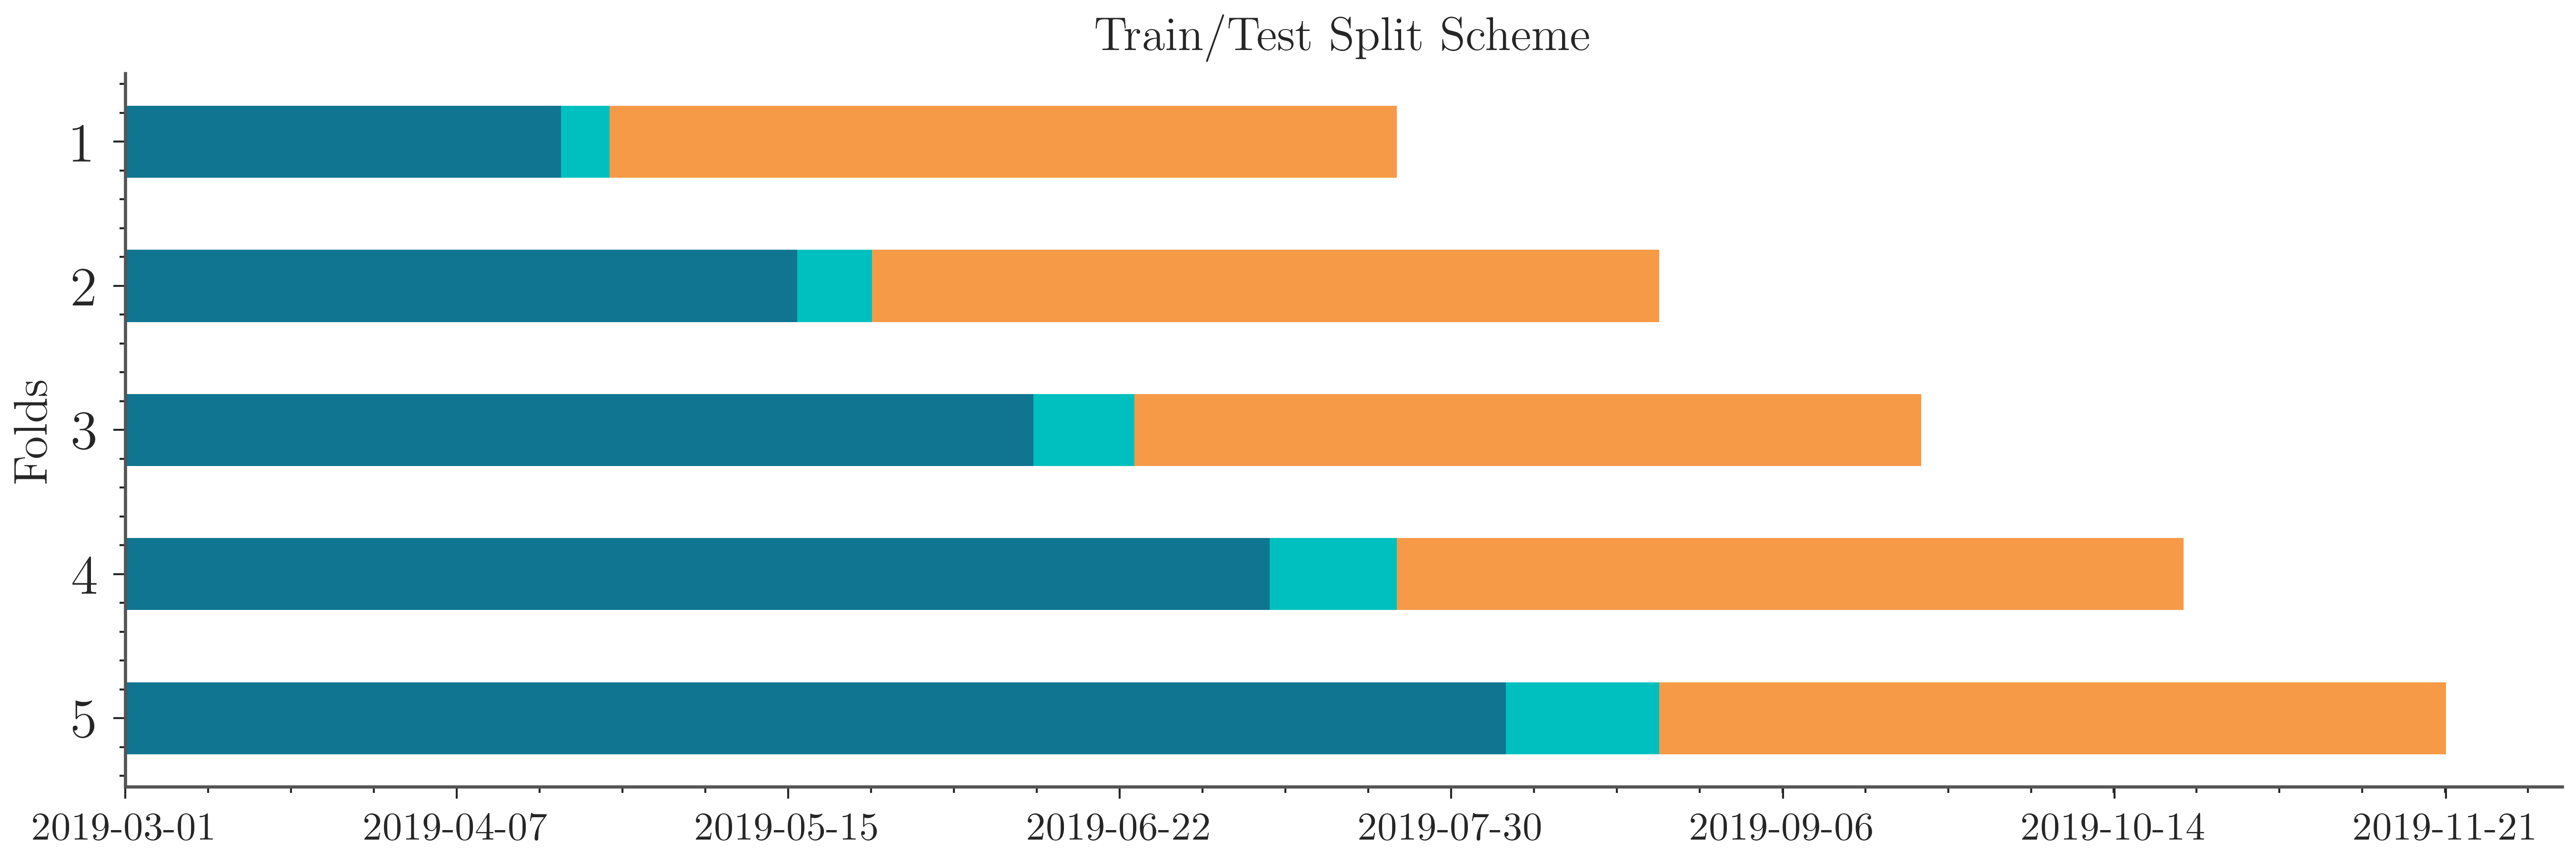

In [171]:
cross_valiadation=BacktestingForecast(data)
cross_valiadation.plot()

In [174]:
metrics_list=[]
metrics_spilit={}
models = StatsForecast(models=[SeasonalNaive(season_length=48), mstl], # model used to fit each time series 
                    freq='30T')
for train_df, test_df, scheme, key in cross_valiadation.generator.split():
    train_df=transform_darts_data(train_df, 'NetLoad')
    test_df=transform_darts_data(test_df, 'NetLoad')
    models.fit(train_df)
    y_hat_df = models.predict(h=len(test_df))
    y_true=test_df['y'].values
    y_pred=y_hat_df['SeasonalNaive'].values
    target_range=y_true.max()-y_true.min()

    metrics_1=get_pointwise_metrics(y_hat_df['SeasonalNaive'].values, y_true, target_range)
    metrics_1['model']='S-Naive'
    metrics_2=get_pointwise_metrics(y_hat_df['MSTL'].values, y_true, target_range)
    metrics_2['model']='MSTL'
    metrics = pd.concat([metrics_1, metrics_2])
    metrics['fold']=key+1
    metrics_list.append(metrics)


In [175]:
metrics=pd.concat(metrics_list)

In [179]:
metrics.groupby('model')[['nrmse', 'mae']].mean()

nrmse       mae
model                      
MSTL     0.136280  6.708186
S-Naive  0.154956  7.720441

# How can we improve this model

In [258]:
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import  NHITS
from neuralforecast.losses.pytorch import DistributionLoss

In [259]:
horizon = 48*7
levels = [0.5, 95]
models = [NHITS(input_size=2 * horizon, h=horizon, max_epochs=50)]
dnn = NeuralForecast(models=models, freq='30T')

In [226]:
train_df=transform_darts_data(data[train], 'NetLoad')
test_df=transform_darts_data(data[test], 'NetLoad')
dnn.fit(df=train_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [227]:
y_hat_df = dnn.predict()
sf.plot(y_hat_df,train_df)

Predicting: 0it [00:00, ?it/s]

In [231]:
y_true=test_df['y'].values[:horizon]
y_pred=y_hat_df['NHITS'].values
target_range=y_true.max()-y_true.min()

metrics=get_pointwise_metrics(y_pred, y_true, target_range)
metrics

nrmse       mae      corr      rmse
0  0.13422  5.032686  0.792133  6.908726

In [256]:
models = [NHITS(input_size=2 * horizon, h=horizon, max_epochs=50,
                loss=MQLoss(level=levels))]
dnn = NeuralForecast(models=models, freq='30T', 
                   )
dnn.fit(df=train_df)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

In [257]:
y_hat_df = dnn.predict()
sf.plot(y_hat_df,train_df)

Predicting: 0it [00:00, ?it/s]